In [ ]:
#https://www.geeksforgeeks.org/how-to-import-kaggle-datasets-directly-into-google-colab/
!pip3 install -q kaggle
!mkdir ~/.kaggle
!echo '{"USERNAME","key":"KEY"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download anasmohammedtahir/covidqu
!unzip -u covidqu.zip

In [ ]:
import os; os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import numpy as np;
import tensorflow.keras as keras; import keras.backend as K;
from tensorflow.keras import optimizers, callbacks, regularizers;
from tensorflow.keras.regularizers import l2;
from tensorflow.keras.models import Sequential, Model;
from tensorflow.keras.layers import Dropout, Conv2D, MaxPooling2D, Dense, Flatten, GlobalAveragePooling2D;
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.preprocessing import image
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
import glob

In [ ]:
def leImagens(wildcards, classes, nl, nc):
  ax = []
  ay = []
  for i, paths in enumerate(wildcards):
    #Agrupando os paths
    dataset = glob.glob(paths); dataset.sort()
    print("Atualmente lendo as fotos de ", paths)
    #Lendo as imagens em grayscale e uint8 para poupar espaço
    for photos in (dataset):
      foto = image.load_img(photos, target_size = (nl, nc), color_mode='grayscale')
      foto = image.img_to_array(foto)
      foto = (foto).astype(np.uint8)
      ax.append(foto)
      ay.append(classes[i])
  #Convertando as imagens para np.array
  ax = np.array(ax)
  ay = np.array(ay)
  return ax, ay

In [ ]:
wildcards=['./Lung Segmentation Data/Lung Segmentation Data/Train/COVID-19/images/*.png',
           './Lung Segmentation Data/Lung Segmentation Data/Train/Non-COVID/images/*.png',
           './Lung Segmentation Data/Lung Segmentation Data/Train/Normal/images/*.png']
classes=[0, 1, 2]
ax,ay = leImagens(wildcards, classes, nl=224, nc=224)
wildcards=['./Lung Segmentation Data/Lung Segmentation Data/Test/COVID-19/images/*.png',
           './Lung Segmentation Data/Lung Segmentation Data/Test/Non-COVID/images/*.png',
           './Lung Segmentation Data/Lung Segmentation Data/Test/Normal/images/*.png',
           './Lung Segmentation Data/Lung Segmentation Data/Val/COVID-19/images/*.png',
           './Lung Segmentation Data/Lung Segmentation Data/Val/Non-COVID/images/*.png',
           './Lung Segmentation Data/Lung Segmentation Data/Val/Normal/images/*.png']
classes=[0, 1, 2, 0, 1, 2]
qx,qy=leImagens(wildcards,classes,nl=224,nc=224)

A função mostraLote recebe uma seed para reprodução das mesmas imagens se necessário

In [ ]:
def mostraLote(x, y=None, seed = None):
  f = plt.figure(figsize=(8, 30))
  if y is None:
    x = shuffle(x, random_state = seed)
  else:
    x, y = shuffle(x, y, random_state = seed)
  for i in range(16):
    if y is None:
      axis = f.add_subplot(16,4,i+1);plt.imshow(x[i],cmap="gray"); plt.axis('off');
    else:
      axis = f.add_subplot(16,4,i+1); axis.title.set_text(y[i]);plt.imshow(x[i],cmap="gray"); plt.axis('off');



Caso 1: Estudando as imagens para futura categorização visual, lembrando que a rotulação é feita com


*   COVID-19 = 0
*   Non COVID = 1
*   Normal = 2







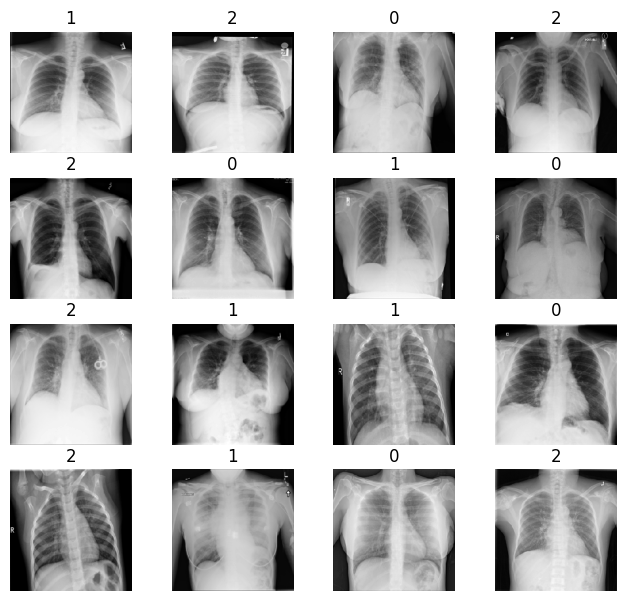

In [ ]:
mostraLote(qx, qy)

Gerando um lote de Imagens sem rótulos para classificação

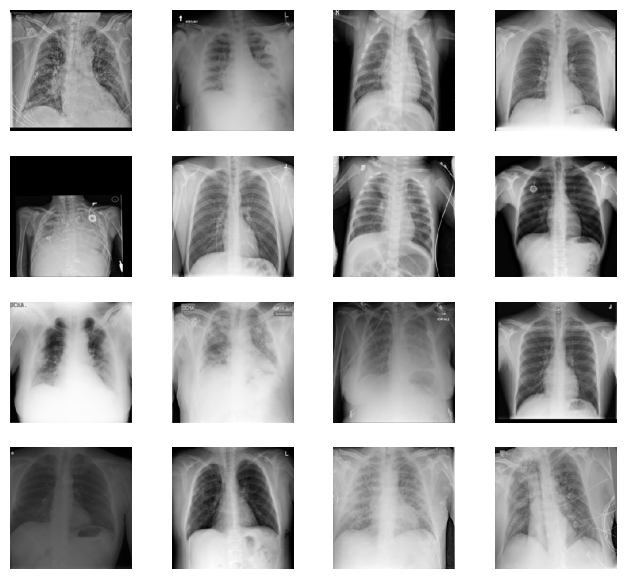

In [ ]:
mostraLote(qx, seed = 225)

Classificação, esquerda pra direita, cima para baixo:


1. COVID-19
2. Non-COVID
3. Non-COVID
4. COVID-19
5. Non-COVID
6. COVID-19
7. Non-COVID
8. Normal
9. Non-COVID
10. Non-COVID
11. Non-COVID
12. Normal
13. COVID-19
14. Normal
15. COVID-19
16. Non-COVID




Ground Truth

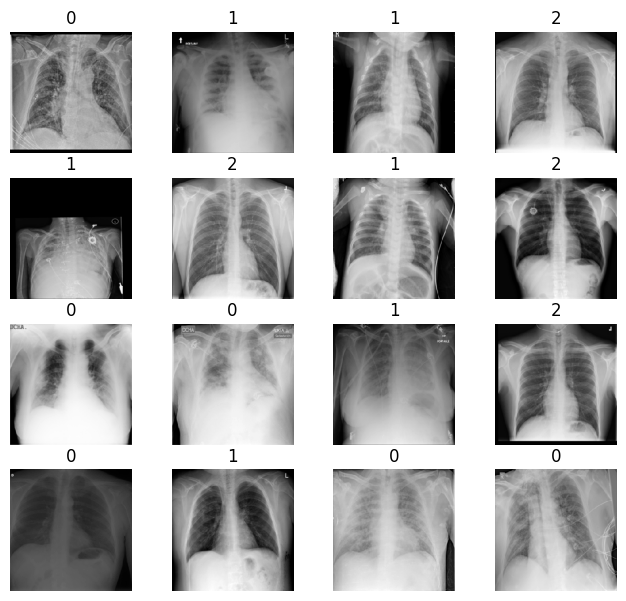

In [ ]:
mostraLote(qx, qy, seed = 225)

PALPITE | TRUTH
1. COVID-19 | *COVID-19*
2. Non-COVID | *Non-COVID*
3. Non-COVID | *Non-COVID*
4. COVID-19 | *Normal*
5. Non-COVID | *Non-COVID*
6. COVID-19 | *Normal*
7. Non-COVID | *Non-COVID*
8. Normal | *Normal*
9. Non-COVID | *COVID-19*
10. Non-COVID | *COVID-19*
11. Non-COVID | *Non-COVID*
12. Normal | *Normal*
13. COVID-19 | *COVID-19*
14. Normal | *Non-COVID*
15. COVID-19 | *COVID-19*
16. Non-COVID | *COVID-19*

Acertos = 10 => Acurácia = 10/16 = 62,5%


In [ ]:
num_classes = 3
ay_one = keras.utils.to_categorical(ay, num_classes)
qy_one = keras.utils.to_categorical(qy, num_classes)


Data generator para não estourar a memória ao treinar a rede

In [ ]:
def data_generator(X, y, batch_size):
    num_samples = X.shape[0]
    while True:
        X, y = shuffle(X, y)  # Shuffle the data for each epoch
        for i in range(0, num_samples, batch_size):
            x_train, y_train = X[i:i+batch_size], y[i:i+batch_size]
            #Concatenando o array com ele mesmo em relação a axis 3 para transformar grayscale em "rgb"
            x_train = np.concatenate((x_train, x_train, x_train), axis = 3)
            yield x_train, y_train

Modelo de rede tipo "LeNET"

In [ ]:
#SEM TRANSFER LEARNING USANDO REDE TIPO LENET
#<<<<<<<<<<<<<<<<<<<<< main <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
nl=224; nc = 224

input_shape = (nl,nc,3); batch_size = 16; epochs = 16;
train_batch_generator = data_generator(ax, ay_one, batch_size)
model = Sequential();
model.add(Conv2D(30, kernel_size=(5,5), activation='relu', input_shape=input_shape, kernel_initializer = 'random_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(40, kernel_size=(5,5), activation='relu', kernel_initializer = 'random_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(50, kernel_size=(5,5), activation='relu', kernel_initializer = 'random_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(60, kernel_size=(5,5), activation='relu', kernel_initializer = 'random_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(1000, activation='relu', kernel_initializer = 'random_normal'))
model.add(Dense(3, activation='softmax', kernel_initializer = 'random_normal'))

opt=optimizers.Adam();
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
#Inserimos aqui o gerador para não estourar a memória
model.fit(
    train_batch_generator,
    epochs = 16,
    batch_size = batch_size,
    steps_per_epoch=len(ax) // batch_size,
    verbose=2,
    shuffle = True)


Epoch 1/16
1357/1357 - 32s - loss: 2.9528 - accuracy: 0.6434 - 32s/epoch - 23ms/step
Epoch 2/16
1357/1357 - 31s - loss: 0.6006 - accuracy: 0.7575 - 31s/epoch - 23ms/step
Epoch 3/16
1357/1357 - 32s - loss: 0.5472 - accuracy: 0.7798 - 32s/epoch - 23ms/step
Epoch 4/16
1357/1357 - 30s - loss: 0.5034 - accuracy: 0.7987 - 30s/epoch - 22ms/step
Epoch 5/16
1357/1357 - 30s - loss: 0.4840 - accuracy: 0.8090 - 30s/epoch - 22ms/step
Epoch 6/16
1357/1357 - 30s - loss: 0.4634 - accuracy: 0.8192 - 30s/epoch - 22ms/step
Epoch 7/16
1357/1357 - 29s - loss: 0.4515 - accuracy: 0.8234 - 29s/epoch - 22ms/step
Epoch 8/16
1357/1357 - 29s - loss: 0.4253 - accuracy: 0.8346 - 29s/epoch - 22ms/step
Epoch 9/16
1357/1357 - 31s - loss: 0.4066 - accuracy: 0.8433 - 31s/epoch - 23ms/step
Epoch 10/16
1357/1357 - 29s - loss: 0.4136 - accuracy: 0.8443 - 29s/epoch - 22ms/step
Epoch 11/16
1357/1357 - 29s - loss: 0.3680 - accuracy: 0.8584 - 29s/epoch - 22ms/step
Epoch 12/16
1357/1357 - 29s - loss: 0.3549 - accuracy: 0.8608 -

In [ ]:
#Como a rede foi treinada usando 3 canais (RGB) é preciso transformar o vetor ax em rgb
batch_size = 16
epochs = 16
def conv_rgb(X, y, batch_size):
    num_samples = X.shape[0]
    for i in range(0, num_samples, batch_size):
      x_train, y_train = X[i:i+batch_size], y[i:i+batch_size]
      x_train = np.concatenate((x_train, x_train, x_train), axis = 3)
      yield x_train, y_train

In [ ]:
train_to_rgb = conv_rgb(ax, ay_one, 100)
test_to_rgb = conv_rgb(qx, qy_one, 100)

In [ ]:
score = model.evaluate(train_to_rgb, verbose=1)
print('Training loss:', score)
score = model.evaluate(test_to_rgb, verbose=1)
print('Test loss:', score)

218/218 [==============================] - 8s 36ms/step - loss: 0.2268 - accuracy: 0.9117
Training loss: [0.22676880657672882, 0.9117200374603271]
123/123 [==============================] - 4s 36ms/step - loss: 0.5691 - accuracy: 0.8331
Test loss: [0.5691305994987488, 0.833101212978363]


In [ ]:
train_batch_generator_transfer = data_generator(ax, ay_one, batch_size)

train_to_rgb_transfer = conv_rgb(ax, ay_one, 100)
test_to_rgb_transfer = conv_rgb(qx, qy_one, 100)

In [ ]:
#TRANSFER LEARNING
num_classes=3; nl=224; nc=224


input_shape = (nl,nc,3); batch_size = 16;

base_model = EfficientNetB7(weights = 'imagenet', include_top=False, input_shape=input_shape)
x = base_model.output
x = GlobalAveragePooling2D()(x) #
x = Flatten()(x) #
predictions = Dense(num_classes, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

#Nao permite treinar base_model. So as camadas densas sao treinadas:
for layer in base_model.layers: layer.trainable = False
#Treina com learning rate grande
otimizador=keras.optimizers.Adam(learning_rate=1e-4)
model.compile(otimizador, loss='categorical_crossentropy', metrics =['accuracy'])
model.fit(
    train_batch_generator_transfer,
    epochs = 8,
    steps_per_epoch=len(ax) // batch_size,
    verbose=2,
    shuffle = True)


258076736/258076736 [==============================] - 1s 0us/step
Epoch 1/8
1357/1357 - 269s - loss: 0.7431 - accuracy: 0.6919 - 269s/epoch - 199ms/step
Epoch 2/8
1357/1357 - 242s - loss: 0.5974 - accuracy: 0.7659 - 242s/epoch - 178ms/step
Epoch 3/8
1357/1357 - 242s - loss: 0.5544 - accuracy: 0.7828 - 242s/epoch - 178ms/step
Epoch 4/8
1357/1357 - 242s - loss: 0.5309 - accuracy: 0.7933 - 242s/epoch - 178ms/step
Epoch 5/8
1357/1357 - 241s - loss: 0.5107 - accuracy: 0.8009 - 241s/epoch - 178ms/step
Epoch 6/8
1357/1357 - 241s - loss: 0.5004 - accuracy: 0.8056 - 241s/epoch - 178ms/step
Epoch 7/8
1357/1357 - 241s - loss: 0.4881 - accuracy: 0.8098 - 241s/epoch - 178ms/step
Epoch 8/8
1357/1357 - 241s - loss: 0.4851 - accuracy: 0.8136 - 241s/epoch - 178ms/step


In [ ]:
score = model.evaluate(train_to_rgb_transfer, verbose=1)
print('Training loss:', score)
score = model.evaluate(test_to_rgb_transfer, verbose=1)
print('Test loss:', score)

218/218 [==============================] - 256s 1s/step - loss: 0.4550 - accuracy: 0.8274
Training loss: [0.4550328254699707, 0.827354371547699]
123/123 [==============================] - 139s 1s/step - loss: 0.4211 - accuracy: 0.8494
Test loss: [0.4211057424545288, 0.8494060039520264]


In [ ]:
#PARA A SEGUNDA INTERAÇÃO
train_batch_generator_transfer = data_generator(ax, ay_one, batch_size)

train_to_rgb_transfer = conv_rgb(ax, ay_one, 100)
test_to_rgb_transfer = conv_rgb(qx, qy_one, 100)

In [ ]:
#Libera todos layers do model (incluindo modelo-base) para treinar:
for layer in model.layers: layer.trainable = True
#Treina com learning rate pequena todas as camadas
model.learning_rate=1e-7
model.fit(
    train_batch_generator_transfer,
    epochs = 8,
    steps_per_epoch=len(ax) // batch_size,
    verbose=2,
    shuffle = True)

Epoch 1/8
1357/1357 - 241s - loss: 0.4796 - accuracy: 0.8145 - 241s/epoch - 178ms/step
Epoch 2/8
1357/1357 - 242s - loss: 0.4689 - accuracy: 0.8187 - 242s/epoch - 179ms/step
Epoch 3/8
1357/1357 - 241s - loss: 0.4619 - accuracy: 0.8223 - 241s/epoch - 178ms/step
Epoch 4/8
1357/1357 - 242s - loss: 0.4602 - accuracy: 0.8220 - 242s/epoch - 178ms/step
Epoch 5/8
1357/1357 - 241s - loss: 0.4558 - accuracy: 0.8240 - 241s/epoch - 178ms/step
Epoch 6/8
1357/1357 - 241s - loss: 0.4547 - accuracy: 0.8243 - 241s/epoch - 178ms/step
Epoch 7/8
1357/1357 - 241s - loss: 0.4449 - accuracy: 0.8299 - 241s/epoch - 178ms/step
Epoch 8/8
1357/1357 - 241s - loss: 0.4442 - accuracy: 0.8292 - 241s/epoch - 178ms/step


In [ ]:
score = model.evaluate(train_to_rgb_transfer, verbose=1)
print('Training loss:', score)
score = model.evaluate(test_to_rgb_transfer, verbose=1)
print('Test loss:', score)

218/218 [==============================] - 238s 1s/step - loss: 0.4167 - accuracy: 0.8418
Training loss: [0.4167335629463196, 0.8417683839797974]
123/123 [==============================] - 129s 1s/step - loss: 0.3836 - accuracy: 0.8614
Test loss: [0.38357123732566833, 0.8613682985305786]
